# Initech analysis

In [1]:
#import useful libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pylab as pylab
import datetime
%matplotlib inline

### Income statement

In [2]:
# import and transpose income statement
inst = pd.read_excel('initech.xlsx',sheet_name='income_stmts', usecols=lambda x: x not in ['Category','Sub-Category']).T
inst.columns = inst.iloc[0]
inst=inst.drop(inst.index[0])

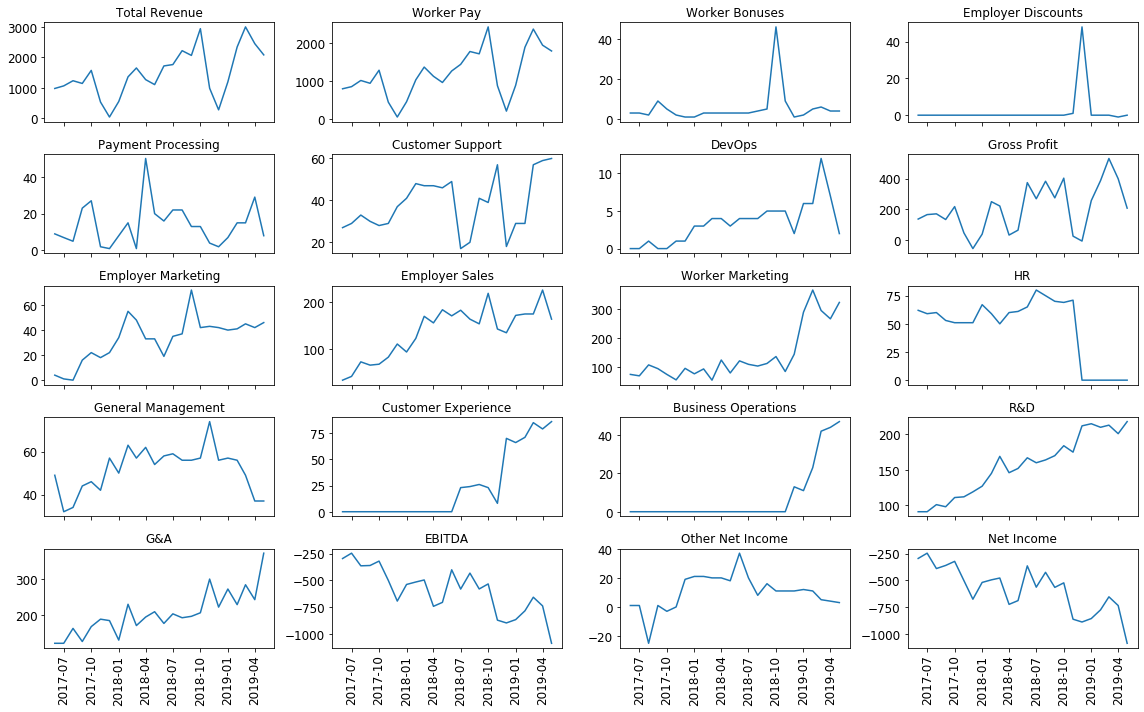

In [3]:
#plot income statement elements over time. Values in 1000 dollars
cols=len(inst.columns)
fig, axes = plt.subplots(nrows = int(cols/4), ncols=4, figsize = (16,10),sharex=True)

for col, ax in zip(inst.columns, axes.flatten()):
    ax.plot(inst.index, inst[col])
    ax.set_title(col)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
fig.tight_layout()

## Exploring employer and worker data

In [4]:
# importing data
employer = pd.read_excel('initech.xlsx',sheet_name='client_data',index_col=0)
worker = pd.read_excel('initech.xlsx',sheet_name='worker_data',index_col=0)
employer.head()

,employer_id,market,revenue,revenue_minus_direct_costs
month,,,,
2015-01-01,9chMy7swbDZ3sqaDCqLlLUQDsMY=,sf-bay-area,0.0,0.0
2015-01-01,3laXJ20VXJNgfEa0zEbBnjD3Cos=,sf-bay-area,250.0,50.0
2015-01-01,nHCU9OfsFRequzQshFD1qypEJVc=,sf-bay-area,250.0,0.0
2015-01-01,khcezEHqw5MZCSE5QdioEP08ZaI=,other,0.0,0.0
2015-02-01,ldW+l2PmzbyDN38Q2cKswMNO6k0=,sf-bay-area,0.0,0.0


In [5]:
# get a feel for the data
print('total employer records = ' + str(len(employer)))
print('total worker records = ' + str(len(worker)))
print('unique employers = ' + str(employer['employer_id'].nunique()))
print('unique workers = ' + str(worker['worker_id'].nunique()))
#print('unique employer markets = ' + str(employer['market'].unique()))
#print('just to check worker markets are same as employer markets: ' + str(worker['market'].unique()))

total employer records = 20637
total worker records = 34968
unique employers = 2243
unique workers = 5928


### Utilization or match rate

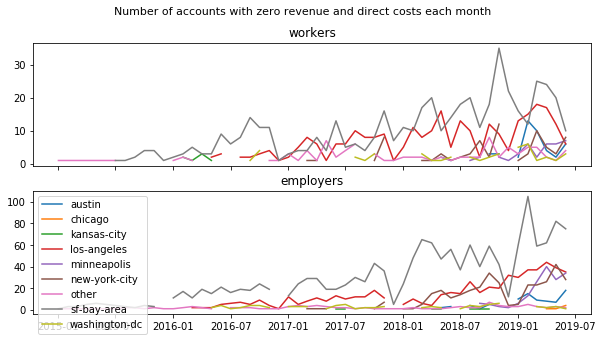

In [6]:
#Find records with zero revenue and revenue_minus_direct_costs
w_uutil=worker[((worker.revenue == 0) & (worker.revenue_minus_direct_costs ==0))]
e_uutil=employer[((employer.revenue == 0) & (employer.revenue_minus_direct_costs ==0))]

#plot under-utilization:
for_legend=w_uutil.groupby(['month','market']).count()['worker_id'].unstack()
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=[10,5])
plt.suptitle('Number of accounts with zero revenue and direct costs each month',size=11);
ax1.plot(w_uutil.groupby(['month','market']).count()['worker_id'].unstack());
ax1.title.set_text('workers');
ax2.plot(e_uutil.groupby(['month','market']).count()['employer_id'].unstack());
ax2.title.set_text('employers');
plt.legend(for_legend.columns, loc="upper left");

## User growth accounting
Note, this code calculates churn, retention, and new + ressurected accounts, and prepares and exports data as excels. The plots you see in the readme are generated in exported excel for now.

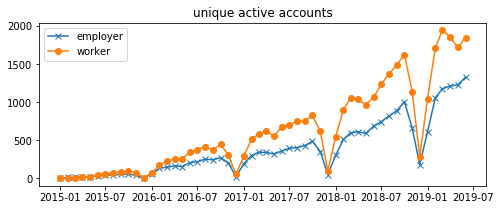

In [7]:
#creating monthly active employers dataframe by counting unique employer IDs
emp_mau = employer.groupby(employer.index)['employer_id'].nunique().reset_index()
wk_mau = worker.groupby(worker.index)['worker_id'].nunique().reset_index()

#simple MAU plot
plt.figure(figsize=[8,3])
plt.plot(emp_mau.month,emp_mau.employer_id,'x-');
plt.plot(wk_mau.month,wk_mau.worker_id,'o-');
plt.title('unique active accounts');
plt.legend(['employer','worker']);

In [8]:
worker_grouped = worker.groupby(['month','worker_id']).sum()
worker_grouped.reset_index(level=1, inplace=True)
wgrowth=pd.DataFrame(worker_grouped.index.unique())
wgrowth['active'],wgrowth['churn'],wgrowth['nr'],wgrowth['retained']=0,0,0,0

In [9]:
# Calculate churn, retention, new & ressurected
for i in range(1,len(wgrowth)):
    cur_m = wgrowth.month[i]
    pre_m = cur_m - pd.DateOffset(months=1)
    wgrowth.active[i]=len(set(pd.Series(worker_grouped.loc[cur_m,'worker_id'])))
    wgrowth.churn[i]=len(set(pd.Series(worker_grouped.loc[pre_m,'worker_id']))-set(pd.Series(worker_grouped.loc[cur_m,'worker_id'])))
    wgrowth.nr[i]=len(set(pd.Series(worker_grouped.loc[cur_m,'worker_id']))-set(pd.Series(worker_grouped.loc[pre_m,'worker_id'])))
    wgrowth.retained[i]=len(set(pd.Series(worker_grouped.loc[cur_m,'worker_id'])).intersection(set(pd.Series(worker_grouped.loc[pre_m,'worker_id']))))
wgrowth.nr[0]=len(set(pd.Series(worker_grouped.loc[wgrowth.month[0],'worker_id'])))
wgrowth.active[0]=wgrowth.nr[0]
wgrowth.head()

,month,active,churn,nr,retained
0,2015-01-01,1,0,1,0
1,2015-02-01,7,0,6,1
2,2015-03-01,7,2,2,5
3,2015-04-01,22,1,16,6
4,2015-05-01,24,6,8,16


In [10]:
# Same thing for employer. *Convert this to a function later.

emp_grouped = employer.groupby(['month','employer_id']).sum()
emp_grouped.reset_index(level=1, inplace=True)
egrowth=pd.DataFrame(emp_grouped.index.unique())
egrowth['active'],egrowth['churn'],egrowth['nr'],egrowth['retained']=0,0,0,0

for i in range(1,len(egrowth)):
    cur_m = egrowth.month[i]
    pre_m = cur_m - pd.DateOffset(months=1)
    egrowth.active[i]=len(set(pd.Series(emp_grouped.loc[cur_m,'employer_id'])))
    egrowth.churn[i]=len(set(pd.Series(emp_grouped.loc[pre_m,'employer_id']))-set(pd.Series(emp_grouped.loc[cur_m,'employer_id'])))
    egrowth.nr[i]=len(set(pd.Series(emp_grouped.loc[cur_m,'employer_id']))-set(pd.Series(emp_grouped.loc[pre_m,'employer_id'])))
    egrowth.retained[i]=len(set(pd.Series(emp_grouped.loc[cur_m,'employer_id'])).intersection(set(pd.Series(emp_grouped.loc[pre_m,'employer_id']))))
egrowth.nr[0]=len(set(pd.Series(emp_grouped.loc[egrowth.month[0],'employer_id'])))
egrowth.active[0]=egrowth.nr[0]

In [11]:
wgrowth['quick_ratio']=wgrowth.nr/wgrowth.churn
wgrowth['retn_rate']=wgrowth.retained/wgrowth.active
egrowth['quick_ratio']=egrowth.nr/egrowth.churn
egrowth['retn_rate']=egrowth.retained/egrowth.active

In [12]:
#Comment out unless you want to over-write excels
#wgrowth.to_excel('wgrowth.xlsx')
#egrowth.to_excel('egrowth.xlsx')

## Revenue growth accounting

In [13]:
# Create a pivot table for revenue. 
# Differnce in revenue month-over-month is calculated using shift, and is used to calculate churn,
# retention, expansion, contraction, new, and ressurected revenue in the next cell.
# *Also generalize this code later

emrr=pd.pivot_table(emp_grouped,values='revenue', index='month', columns='employer_id',fill_value=0)
eexp=emrr-emrr.shift(1)
eexp.fillna(0,inplace=True)

In [14]:
emr=pd.DataFrame(eexp.index)
emr['exp'],emr['con'],emr['new'],emr['retained'],emr['ress'],emr['churn']=0,0,0,0,0,0
for c in eexp:
    uid=eexp[c]
    xid=emrr[c]
    first=0
    for i,val in enumerate(uid):
        if (i==0 and xid[0]>0):
            first=1
            emr.new[i]+=xid[0]
        elif (i==0 or i ==len(uid)-1):
            pass
        elif (val==0 and uid[i-1]==0):
            pass
        elif (first==0 and val>0): 
            first=1
            emr.new[i]+=val
        elif (val>0 and xid[i-1]>0 and first==1):
            emr.exp[i]+=val
            emr.retained[i]+=xid[i-1]
        elif (val>0 and xid[i-1]==0 and first==2):
            emr.ress[i]+=val
        elif (val<0 and xid[i]==0):
            emr.churn[i]+=val
            first=2
        elif val<0:
            emr.con[i]+=val
            emr.retained[i]+=xid[i]
            first=2
emr['total_rev']=emrr.sum(axis=1).reset_index()[0]
#emr.to_excel('emr.xlsx') #        

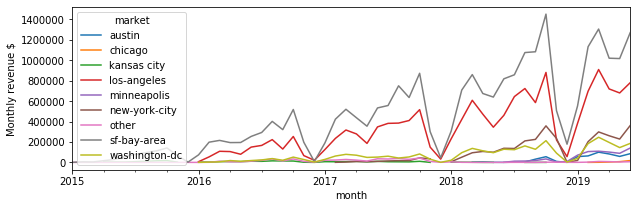

In [15]:
employer.groupby(['month','market']).sum()['revenue'].unstack().plot(figsize=[10,3])
#plt.plot(worker.groupby(['month','market']).sum()['revenue'].unstack()); #identical when overlain 
plt.ylabel('Monthly revenue $');

## Distribution of account sizes

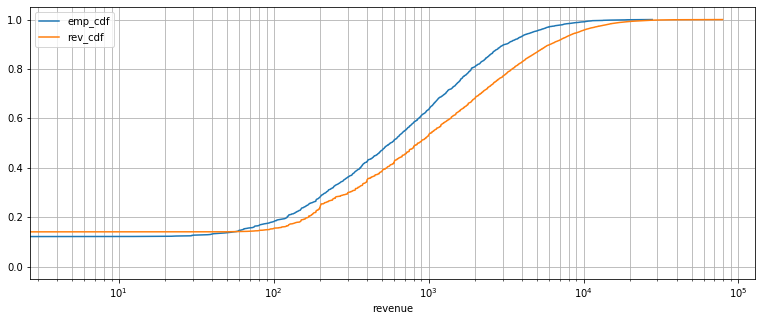

In [16]:
ecdf=pd.DataFrame(emp_grouped.groupby('employer_id').mean().revenue)
ecdf['emp_cdf'] = ecdf.rank(method = 'average', pct = True)

#ecdf=pd.DataFrame(emp_grouped.groupby('employer_id').mean().revenue)
ercdf=pd.DataFrame(emp_grouped.revenue)
ercdf['rev_cdf'] = ercdf.rank(method = 'average', pct = True)

#wcdf=pd.DataFrame(worker_grouped.groupby('worker_id').mean().revenue)
#wcdf['user_cdf'] = wcdf.rank(method = 'average', pct = True)

ax=ecdf.sort_values('revenue').plot(x = 'revenue', y = 'emp_cdf', figsize=[13,5])
ercdf.sort_values('revenue').plot(x = 'revenue', y = 'rev_cdf', ax=ax)
#wcdf.sort_values('revenue').plot(x = 'revenue', y = 'cdf', ax=ax,label='worker')
ax.grid(which='both', axis='both')
ax.set_xscale('log')

## Cohort LTV

In [17]:
# Run only once #added_cohort
employer.reset_index(inplace=True)
worker.reset_index(inplace=True)
wcohort=worker.groupby('worker_id')['month'].min().to_frame()
ecohort=employer.groupby('employer_id')['month'].min().to_frame()
emp_grouped['cohort']=[ecohort.month[emp_id] for emp_id in emp_grouped.employer_id]
worker_grouped['cohort']=[wcohort.month[w_id] for w_id in worker_grouped.worker_id]

In [18]:
#converting months to quarters

quarter=pd.DataFrame(emp_grouped.cohort.unique())
quarter=quarter.reset_index()
quarter.columns=['quarter','cohort']

for i in quarter.index:
    quarter['quarter'][i]=i//3+1
quarter.set_index('cohort',inplace=True)
quarter.head()

,quarter
cohort,
2015-01-01,1
2015-02-01,1
2015-03-01,1
2015-04-01,2
2015-05-01,2


In [19]:
q_cohort=emp_grouped.copy() #to not mess with the original frame that might come in handy later
q_cohort.cohort=[quarter.loc[i].quarter for i in q_cohort.cohort] #month to quarter
q_pivoted=q_cohort.groupby(['month','cohort']).sum()['revenue'].unstack() #unstack

In [21]:
# Revenue by cohort by quarter!!
q_cohort=emp_grouped.copy() #to not mess with the original frame that might come in handy later
q_cohort.cohort=[quarter.loc[i].quarter for i in q_cohort.cohort] #month to quarter
q_pivoted=q_cohort.groupby(['month','cohort']).sum()['revenue'].unstack() #unstack


In [22]:
cohort_size=pd.DataFrame(q_cohort.groupby(['cohort']).agg('nunique')['employer_id'])

In [23]:
q_norm=q_pivoted.copy()
for col in q_pivoted:
    q_norm[col]=q_norm[col]/int(cohort_size.loc[col])

In [24]:
#Sum over previous months to get value_so_far
q_sum = q_norm.copy()
q_sum=q_sum.fillna(0)
for index, row in q_sum.iterrows():
    if index==pd.Timestamp('2015-01-01'):
        row1=row
    else:
        q_sum.loc[index,:]=row1+row
        row1=row

In [25]:
q_sum=q_sum.reset_index()
q_sum=q_sum.drop('month',axis=1)


In [26]:
q_periods = q_sum.replace({0:np.nan})
q_periods = q_periods.apply(lambda x: pd.Series(x.dropna().values))

In [27]:
q_periods.index += 1 
new_row=pd.DataFrame(0,index=np.arange(1),columns=q_periods.columns)
q_periods=pd.concat([new_row,q_periods]).reset_index(drop=True)


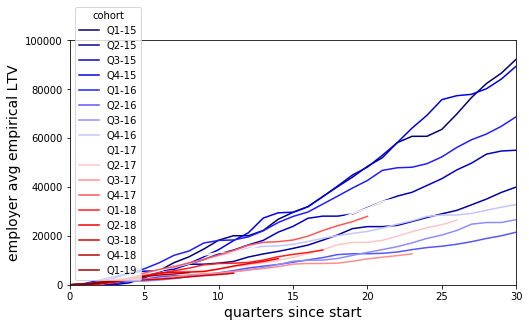

In [28]:
plt.figure(figsize=[8,4.5])
colors = pylab.cm.seismic(np.linspace(0,1,19))
for col in q_periods:
    plt.plot(q_periods[col],color=colors[col])
plt.xlabel('quarters since start',size=14);
plt.ylabel('employer avg empirical LTV',size=14);
plt.xlim(0,30);
plt.ylim(0,100000);
plt.legend(title='cohort',labels=['Q1-15','Q2-15','Q3-15','Q4-15','Q1-16','Q2-16','Q3-16','Q4-16','Q1-17','Q2-17','Q3-17','Q4-17','Q1-18','Q2-18','Q3-18','Q4-18','Q1-19']);

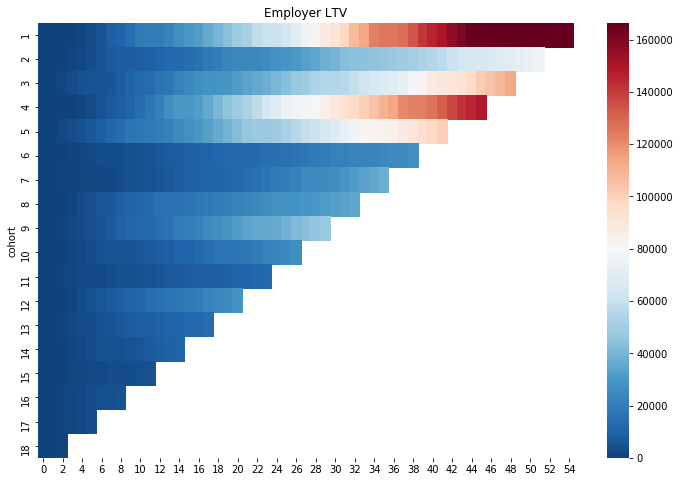

In [29]:
plt.figure(figsize=[12,8])
plt.title('Employer LTV');
plt.xlabel('Months since cohort start');
ax=sns.heatmap(q_periods.T, mask=q_periods.T.isnull(), cmap="RdBu_r",center=80000,robust=True);